In [1]:
#시각화 한글 보여주기 -> 설치하고 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rfz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,459 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 156210 files and d

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa 불러오기(파이썬 음성 분석 라이브러리) -> 음성시각화 및 벡터화 지원
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# 오디오파일 재생 라이브러리
from IPython.display import Audio

#케라스 불러오기
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

#오류무시
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
from google.colab import drive #코랩과 연결
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#감성대화 음성데이터 압축풀기
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/감성대화/원천데이터/감성대화말뭉치(원천데이터)_음성데이터.zip"

In [6]:
#감성대화 라벨데이터 불러오기
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/감성대화/감성대화말뭉치_table.xlsx')
data_w = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/감성대화/감성대화말뭉치_w_table.xlsx')
#감정 및 음성데이터경로만 뽑아오기
data2 = data.loc[:,['감정_대분류','NO.']]
data2.columns = ['Emotions','Path']

data2_w = data_w.loc[:,['감정_대분류','NO.']]
data2_w.columns = ['Emotions','Path']

# 음성데이터 경로수정해주기(압축푼 폴더로)
## 남자 성우만 이용하도록 돼 있음!!!!!!!!!!!!!!11111
data2['Path'] = '/content/감성대화말뭉치AI데이터_Wave_남자성우_5000/'+data2['Path']+'.wav'
data2_w['Path'] = '/content/감성대화말뭉치AI데이터_Wave_여자성우_5000/'+data2_w['Path']+'.wav'

new_data = pd.concat([data2, data2_w])

#당황, 불안 빼는 건 다운샘플링 이후에 뺌
data_new = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/감성대화/csv/KESDy18_csv.csv', index_col = 0)

data3 = pd.concat([new_data, data_new])
# 감정데이터중에 '당황'라벨 제거해주기
## 불안도 빼기__________________________________________________________
data_path = data3[data3['Emotions']!='당황']
data_path = data_path[data_path['Emotions']!='불안']
data_path.tail(100)
#data_path.to_csv('/content/drive/MyDrive/Colab Notebooks/감성대화/all.csv')

,Emotions,Path
2780,분노,/content//drive/MyDrive/Colab Notebooks/감성...
2781,중립,/content//drive/MyDrive/Colab Notebooks/감성...
2782,분노,/content//drive/MyDrive/Colab Notebooks/감성...
2783,분노,/content//drive/MyDrive/Colab Notebooks/감성...
2784,분노,/content//drive/MyDrive/Colab Notebooks/감성...
...,...,...
2875,기쁨,/content//drive/MyDrive/Colab Notebooks/감성...
2876,중립,/content//drive/MyDrive/Colab Notebooks/감성...
2877,기쁨,/content//drive/MyDrive/Colab Notebooks/감성...
2878,중립,/content//drive/MyDrive/Colab Notebooks/감성...


In [7]:
data_path['Emotions'].value_counts()

슬픔    2411
기쁨    2399
분노    2380
상처    1666
중립     720
Name: Emotions, dtype: int64

In [8]:
data_path.dropna()

,Emotions,Path
0,상처,/content/감성대화말뭉치AI데이터_Wave_남자성우_5000/M_000001.wav
1,상처,/content/감성대화말뭉치AI데이터_Wave_남자성우_5000/M_000002.wav
2,상처,/content/감성대화말뭉치AI데이터_Wave_남자성우_5000/M_000003.wav
3,상처,/content/감성대화말뭉치AI데이터_Wave_남자성우_5000/M_000004.wav
4,상처,/content/감성대화말뭉치AI데이터_Wave_남자성우_5000/M_000005.wav
...,...,...
2875,기쁨,/content//drive/MyDrive/Colab Notebooks/감성...
2876,중립,/content//drive/MyDrive/Colab Notebooks/감성...
2877,기쁨,/content//drive/MyDrive/Colab Notebooks/감성...
2878,중립,/content//drive/MyDrive/Colab Notebooks/감성...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
findfont: Font family ['SangSangTitleB'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SangSangTitleB'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lo

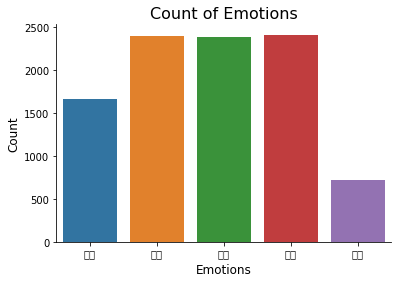

In [9]:
# 도표 및 그림에서 한글사용하기
plt.rc('font', family='SangSangTitleB') 

# 감정의 전체적인 분포 확인하기
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [10]:
# 음성데이터를 waveplot, spectrogram 이미지로 표현

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft 함수는 음성을 시간기반에서 주파수기반으로 변환함
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

findfont: Font family ['SangSangTitleB'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49836 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54548 missing from current font.
  font.set_text(s, 0, flags=flags)


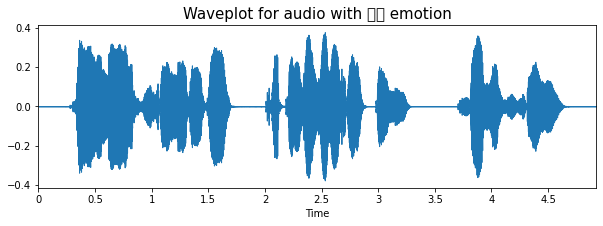

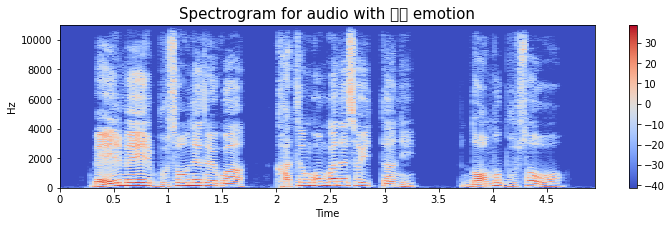

In [11]:
#슬픔 음성데이터 예시로 보기
emotion='슬픔'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [12]:
# 음성데이터 argumentation을 통해서 데이터 수 늘리기 및 오버피팅 방지
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    ## np.random.uniform() 모수 설정해주는 함수
    ## np.amax data의 최댓값을 반환함
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
    ## rate 만큼 늘려줌, 빠르기 조절

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    ## shift_range 밀어주는 정도
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
    ## 파형 피치 조정

# 예시
## 위에서 지정해줌
#$path = np.array(data_path.Path)[1]
#data, sample_rate = librosa.load(path)


# 음성의 특성추출하는 함수 ( MFCC, MEL, RMSV)
# spectrum으로 변환
def extract_features(data):

    result = np.array([])

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    #rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    #result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

# 음성의 특성을 추출한 데이터를 축적하는 함수 (Argumentation된 데이터도 같이)
def get_features(path):
    # duration과 offset은 각 오디오 파일의 시작과 끝에서 오디오가 없는 것을 처리
    #data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    data, sample_rate = librosa.load(path)
    
    # 원래데이터
    res1 = extract_features(data)
    result = np.array(res1)
    # 노이즈가 추가된 데이터
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # 병렬적으로 추가

    # 피칭및 스트레칭된 데이터
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # 병렬적으로 추가

    # 시프트된 데이터
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result, res4)) # 병렬적으로 추가

    return result

In [13]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        ## ele : spectrum
        # 2개의 augmentation이 존재하므로 총 한개의 음성데이터가 3개의 음성데이터가 됨
        Y.append(emotion)

In [14]:
len(X), len(Y), data_path.Path.shape

(38304, 38304, (9576,))

In [15]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,labels
0,-344.657074,98.720970,16.489840,18.843010,8.627206,1.718554,10.197598,7.275743,-7.786025,2.359055,...,0.003202,0.002444,0.002785,0.002915,0.002401,0.002712,0.002080,0.000614,0.000036,상처
1,-178.456712,36.289623,16.679329,10.886721,6.531644,2.794180,4.261281,0.542311,-3.562766,-2.255276,...,0.015583,0.014836,0.014982,0.014456,0.013890,0.014676,0.013677,0.012102,0.011481,상처
2,-394.910095,95.638672,14.291139,17.361364,5.681870,1.678648,11.347850,2.720121,-9.487573,1.547513,...,0.000668,0.000789,0.000614,0.000582,0.000752,0.000462,0.000362,0.000122,0.000008,상처
3,-344.674561,98.817612,16.457277,18.835936,8.530676,1.783618,10.038803,7.181270,-7.915461,2.315263,...,0.003202,0.002444,0.002785,0.002915,0.002401,0.002712,0.002080,0.000614,0.000036,상처
4,-363.084595,83.926949,18.430622,20.694668,11.173538,5.064193,9.867046,7.276873,-2.569465,2.289418,...,0.004862,0.001993,0.003868,0.003755,0.003171,0.002826,0.001413,0.000566,0.000044,상처


In [16]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [17]:
# 다중 클래스 분류하기위해 Y설정
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [18]:
# 훈련데이터, 테스트데이터 분리
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, stratify= Y, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((28728, 148), (28728, 5), (9576, 148), (9576, 5))

In [19]:
# 훈련 및 테스트데이터 갯수 확인
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((28728, 148), (28728, 5), (9576, 148), (9576, 5))

In [20]:
# 데이터의 차원 모델에 맞게 통일 
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((28728, 148, 1), (28728, 5), (9576, 148, 1), (9576, 5))

In [21]:
!pip install focal_loss

     |████████████████████████████████| 462 kB 6.8 MB/s 


In [22]:
from keras import backend as K
import tensorflow as tf
from focal_loss import BinaryFocalLoss

In [23]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='elu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='elu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='elu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='elu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(units=5, activation='softmax'))
###6_______________
model.compile(optimizer = 'adam' , loss = BinaryFocalLoss(gamma=2, pos_weight = 0.8) , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 148, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 256)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 74, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 256)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 256)           0

In [24]:
#모델1 훈련
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.5, verbose=0, patience=3, min_lr=0.000005)
#monitor : 기준으로 삼을 값, factor : learning rate를 얼마나 감소시킬지 정하는 인자값, patience : 모니터되는 값의 개선이 없을 경우 얼마나 더 작동시키고 learning rate를 감소 적용할지, verbose : 화면 표기 없이 걍 종료
history1 = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp]) #배치 사이즈가 작다
#65번째 learning rate가 조절된 이후 test 입장에서 학습 결과가 더 안 좋아진다

Epoch 1/100
449/449 [==============================] - 19s 13ms/step - loss: 0.1335 - accuracy: 0.4093 - val_loss: 0.1111 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 5s 12ms/step - loss: 0.1116 - accuracy: 0.4826 - val_loss: 0.0972 - val_accuracy: 0.5541 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 5s 10ms/step - loss: 0.1013 - accuracy: 0.5330 - val_loss: 0.0895 - val_accuracy: 0.5819 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 4s 9ms/step - loss: 0.0938 - accuracy: 0.5670 - val_loss: 0.0842 - val_accuracy: 0.6103 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 4s 9ms/step - loss: 0.0875 - accuracy: 0.5933 - val_loss: 0.0771 - val_accuracy: 0.6511 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 4s 9ms/step - loss: 0.0826 - accuracy: 0.6192 - val_loss: 0.0726 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 7/100
449/449 [==============================] - 4s 9m

콜백함수가 필요한 이유: 모델이 학습을 시작하면 학습이 완료될 때까지 사람이 할 수 있는게 없습니다. 따라서 이를 해결하고자 존재하는 것이 콜백함수입니다. 예를 들어, 학습되는 과정 사이에 학습률을 변화시키거나 val_loss가 개선되지 않으면 학습을 멈추게 하는 등의 작업을 할 수 있습니다.

출처: https://deep-deep-deep.tistory.com/1 [딥딥딥]

In [25]:
from keras.models import load_model
model.save('ser_model.h5')

300/300 [==============================] - 1s 3ms/step - loss: 0.0285 - accuracy: 0.9167
Accuracy of our model on test data :  91.66666865348816 %


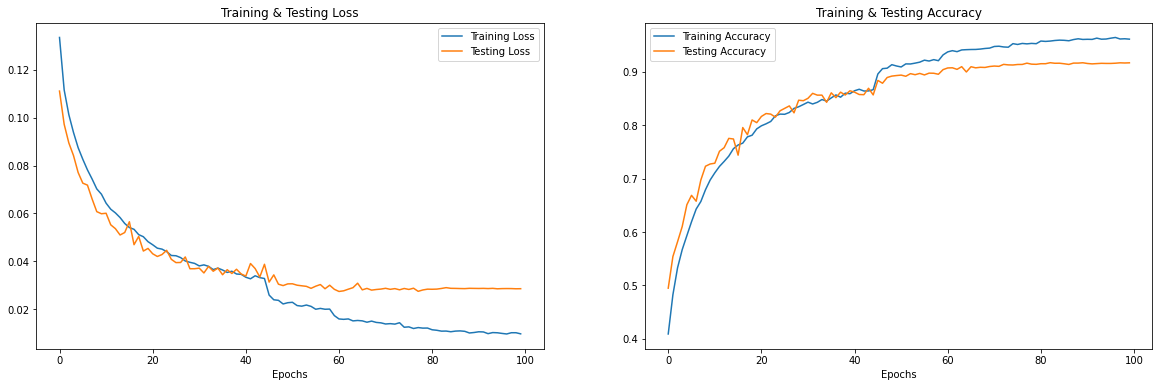

In [26]:
#모델1 그래프
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
test_acc = history1.history['val_accuracy']
test_loss = history1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [27]:
# 모델2 테스트데이터 적용
pred_test = model.predict(x_test)
pred_test
y_pred = encoder.inverse_transform(pred_test)
y_test2 = encoder.inverse_transform(y_test)

아직 loss는 계속 떨어지는 추세 입니다. 이럴 경우 모델이 아직 saturation이 안되었다고 말합니다. 모델이 잘 만들어졌고, 데이터도 적절하다면 훈련을 지속했을때 train set loss와 validation set loss가 같이 떨어지다가, 어느 순간 validation set loss가 상승하는 경우를 볼 수 있습니다. 일반적으로 그 지점에서 훈련을 중단합니다. 그 전에 훈련을 멈추면, 언더피팅인 상태고, 훈련을 더 계속하면 오버피팅 상태로 보는 것이죠. 이런 방식으로 훈련의 시간을 정하는 방식을 Early Stopping이라고도 부릅니다.

In [28]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test2

df.to_csv('/content/drive/MyDrive/Colab Notebooks/감성대화/all_result.csv')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49256 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45432 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52376 missing from current font.
  font.set_

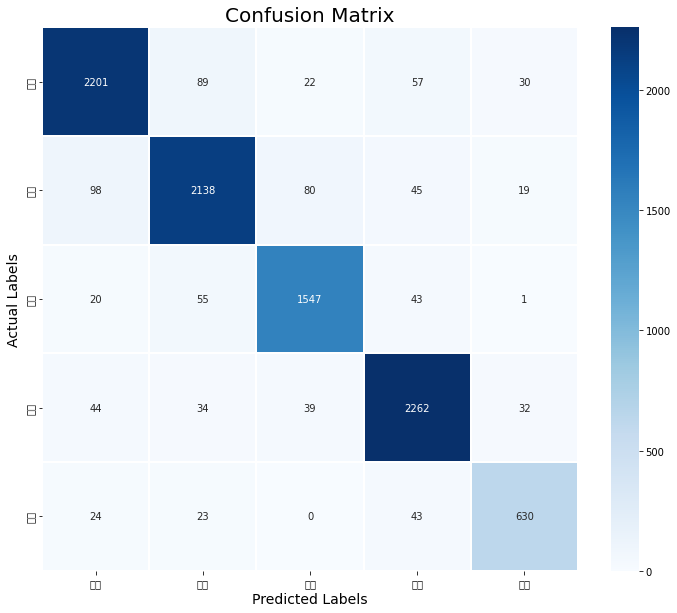

In [29]:
cm = confusion_matrix(y_test2, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [30]:
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

          기쁨       0.92      0.92      0.92      2399
          분노       0.91      0.90      0.91      2380
          상처       0.92      0.93      0.92      1666
          슬픔       0.92      0.94      0.93      2411
          중립       0.88      0.88      0.88       720

    accuracy                           0.92      9576
   macro avg       0.91      0.91      0.91      9576
weighted avg       0.92      0.92      0.92      9576



- precision : 정밀도
- Recall : 재현율, 실제 양성 클래스에 속한 샘플 중 양성 클래스라고 예측한 샘플 수의 비율
- Accuracy : 정확도
- F1-score : 가중 조화평균??
- support : 각 라벨의 실제 샘플 개수
- macro avg : 단순 평균
- weighted avg : 가중 평균(샘플 개수의 불균형 고려)

#동영상 넣기

In [31]:
!pip install moviepy
!pip install pydub

In [32]:
import os
import librosa
import numpy as np
import librosa
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
from pydub import AudioSegment
import wave
import soundfile as sf
import moviepy.editor as mp

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2932736/45929032 bytes (6.4%)7036928/45929032 bytes (15.3%)11165696/45929032 bytes (24.3%)15024128/45929032 bytes (32.7%)19079168/45929032 bytes (41.5%)23085056/45929032 bytes (50.3%)26107904/45929032 bytes (56.8%)28983296/45929032 bytes (63.1%)32940032/45929032 bytes (71.7%)36995072/45929032 bytes (80.5%)41246720/45929032 bytes (89.8%)45441024/45929032 bytes (98.9%)

In [33]:
mp4_save = "/content/drive/MyDrive/SUMVID_SHORT_TRAIN_01/"
mp4_list = os.listdir(mp4_save)

for mp4_name in mp4_list:
  if mp4_name.find('mp4') is not -1:
    name = mp4_name[:-4]
    a = "/content/drive/MyDrive/SUMVID_SHORT_TRAIN_01/" + name + ".mp4"
    clip = mp.VideoFileClip(a)
    clip.audio.write_audiofile("audio.mp3")

    src = "audio.mp3"
    dst = "test.wav"
    sound = AudioSegment.from_mp3(src) # load file as extention 'mp3' 
    sound.export(dst, format="wav") # convert file to wav

    import math

    sound2 = AudioSegment.from_mp3("test.wav")

    two_seconds = 3*1000

    for i in range(int(math.floor(len(sound2)/3000))):
      slice = sound2[i*two_seconds:two_seconds*(i+1)]
      slice.export(name+'_{}.wav'.format(i), format = "wav")

    import glob
    sound_path = glob.glob('/content/'+name+'*.wav')

    def gfs(path):
      # duration과 offset은 각 오디오 파일의 시작과 끝에서 오디오가 없는 것을 처리 (duration : 로드할 오디오 길이, offset : 앞뒤 이정도 자르기)
      #data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
      data, sample_rate = librosa.load(path)
    
      # 원래데이터
      res1 = extract_features(data)
      result = np.array(res1)

      return result 

    Z = []
    for path in sound_path:
        feature = gfs(path)
        for ele in feature:
            Z.append(ele)
            # 2개의 augmentation이 존재하므로 총 한개의 음성데이터가 3개의 음성데이터가 됨 (stretch한거랑 noise 더한 것)

    Z = np.array(Z)
    a = str(Z.shape)
    a = a[1:-2]

    b = int(a) / 148
    W=Z.reshape(int(b),148)

    ExperimentFeatures = pd.DataFrame(W)
    ExperimentFeatures.to_csv(name+'.csv', index=False)
    ExperimentFeatures.shape

    EF = ExperimentFeatures.iloc[: ,:].values
    EF = scaler.transform(EF)

    EF = np.expand_dims(EF, axis=2)

    from keras.models import load_model
    model = load_model('ser_model.h5')

    pred_test = model.predict(EF)

    EF_pred = encoder.inverse_transform(pred_test)
    df = pd.DataFrame(columns=['Predicted Labels'])
    df['Predicted Labels'] = EF_pred.flatten()

    df.to_csv('/content/drive/MyDrive/Colab Notebooks/감성대화/'+name+'.csv', index=False)

[MoviePy] Writing audio in audio.mp3


100%|██████████| 77302/77302 [01:29<00:00, 861.81it/s] 

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 78534/78534 [01:24<00:00, 927.95it/s] 

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 78251/78251 [01:25<00:00, 912.93it/s] 

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 77976/77976 [01:28<00:00, 884.26it/s] 

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 74108/74108 [01:25<00:00, 869.85it/s] 

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 73583/73583 [01:26<00:00, 855.07it/s] 

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 77510/77510 [01:27<00:00, 890.04it/s] 

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 80482/80482 [01:30<00:00, 887.00it/s] 

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 73475/73475 [01:03<00:00, 1153.81it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 70962/70962 [01:01<00:00, 1146.02it/s]

[MoviePy] Done.


In [ ]:
#_______________________________________________________________________________________________________________